# Comparative Analysis: Supervised vs. Unsupervised Methodologies  
In this project, we analyze the ESC-50 audio dataset using two distinct machine learning paradigms. Understanding the similarities and differences between these approaches is crucial for interpreting our results.  

1. Similarities (The Common Foundation)To ensure a fair comparison, the input pipeline remains identical for both methods. This isolates the algorithm's logic as the only variable.  
**Feature Extraction:** Both methods use the exact same mathematical representation of sound (80 features including MFCCs, Spectral Centroid, ZCR, etc.). We do not change the features; we only change how the model interprets them.  
**Data Preprocessing:** Standardization (Scaling) is applied in both cases. In SVM/RF (Supervised), scaling ensures the hyperplane or decision boundary is not biased. In K-Means (Unsupervised), scaling is even more critical because the algorithm relies on Euclidean distance. Without scaling, features with larger magnitudes (like Frequency) would dominate the clustering process.  
**Target Classes:** We focus on the same subset of 10 audio categories to maintain consistency in complexity.  

2. Differences (The Algorithmic Logic)The divergence lies in how the models interact with the data during the training phase.  
**A. Input Data Requirements** Supervised Learning: The model requires both the features ($X$) and the correct answers or labels ($y$) during training. It learns the relationship between the sound (MFCCs) and the name ("Dog").Unsupervised Learning: The model requires only the features ($X$). It is blind to the labels ($y$) during the learning process.  
**B. The Training Command** Supervised: We execute model.fit(X, y). This tells the model: "Here is the data, and here is what it should be."Unsupervised: We execute model.fit(X). This tells the model: "Here is the data; find the structure yourself.  
**C. The Learning Process** Supervised (Guided): This is analogous to a student learning with a teacher. The model makes a guess, the teacher (the algorithm) corrects it based on the known label, and the model adjusts to minimize the error.Unsupervised (Self-Discovery): This is analogous to a student sorting a pile of unknown photographs. The model looks at the data points and tries to group similar items together based on mathematical distance (e.g., Euclidean distance), effectively minimizing the distance between points within the same group.  
**D. The Ultimate Goal** Supervised: The goal is Classification. We want the model to correctly predict the label of a new, unseen sound file.Unsupervised: The goal is Clustering. We want the model to discover hidden structures or natural groupings within the audio data.  

3. The Role of Labels in Unsupervised LearningA common question in unsupervised learning is: "If the model doesn't use labels, why do we define and load categories?"We use the labels (Ground Truth) strictly for Evaluation, never for Training.  
**During Training (The "Blind" Phase):** We hide the labels from the K-Means algorithm. It groups the sounds purely based on their acoustic similarity. For example, it might group all high-pitched, noisy sounds into "Cluster 1."  
**During Evaluation (The "Reveal" Phase):** Once the clustering is finished, we "reveal" the true labels to check the quality of the clusters. We analyze whether "Cluster 1" actually contains mostly 'Rain' sounds or if the model confused 'Rain' with 'Wind'.Analogy:Supervised: Taking a practice test with the answer key attached. You learn by checking your answers immediately.Unsupervised: Sorting a deck of cards without knowing the suits. You group them by visual pattern, and only at the end does someone tell you if you correctly separated the Hearts from the Diamonds.

# Import Necessary Libraries 

In [1]:
import pandas as pd
import numpy as np
import yaml as yml
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import warnings

# Machine Learning Imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from sklearn.cluster import KMeans


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plot styling
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- Configuration & Path Setup ---
# Tries to load from config.yml, falls back to default if missing
try:
    with open("config.yml", "r") as f:
        config = yml.safe_load(f)
    file_path = config["file_path"]
    audio_path = config["audio_path"]
    print("✅ Loaded paths from config.yml")
except FileNotFoundError:
    # FALLBACK PATHS (Update these if necessary)
    file_path = "ESC-50-master/meta/esc50.csv" 
    audio_path = "ESC-50-master/audio/"
    print(f" config.yml not found. Using default paths: {audio_path}")

print(f"Metadata file: {file_path}")
print(f"Audio directory: {audio_path}")

✅ Loaded paths from config.yml
Metadata file: esc50.csv
Audio directory: ESC-50-master/ESC-50-master/audio


# Data Loading, Feature Extraction & Scaling
1. Data Acquisition, Feature Extraction, and PreprocessingIn this section, we transform raw audio signals into a structured numerical dataset suitable for unsupervised machine learning algorithms. Unlike supervised learning, where we rely on labels, unsupervised algorithms (like K-Means and PCA) rely heavily on the geometric structure of the data. Therefore, feature consistency and scaling are critical.1. Data Loading and FilteringWe utilize the ESC-50 dataset, filtering it down to specific categories of interest (e.g., Animals, Natural Soundscapes, Human Sounds). This reduces noise and allows us to focus on distinct acoustic patterns.  

2. Feature Extraction (The "Fingerprint" of Sound)Raw audio waveforms are high-dimensional and difficult to process directly. We use librosa to extract 80 distinct features that mathematically describe the acoustic properties of each clip. These features include:MFCCs (Mel-Frequency Cepstral Coefficients): Represents the short-term power spectrum of sound. It effectively captures the timbre or "color" of the audio (e.g., distinguishing a violin from a flute).Spectral Features:Spectral Centroid: Indicates the "brightness" of a sound (center of mass of the spectrum).Spectral Rolloff & Bandwidth: Measures the shape and range of the frequency distribution.Zero Crossing Rate (ZCR): Measures the rate of sign-changes in the signal, often high in percussive or noisy sounds (like rain or static).Temporal & Harmonic Features:Pitch: Estimates the fundamental frequency.HNR (Harmonic-to-Noise Ratio): Distinguishes between harmonic sounds (musical) and noise (wind, rain).  

3. Standardization (Crucial for Unsupervised Learning)Unsupervised algorithms often calculate the Euclidean distance between data points to form clusters.The Problem: Our features have vastly different scales. For example, Spectral Centroid might range from 0 to 5000 Hz, while RMS Energy ranges from 0 to 1. Without scaling, the algorithm would be biased entirely toward frequency features simply because the numbers are larger.The Solution: We apply Standard Scaling (Z-score normalization):$$z = \frac{x - \mu}{\sigma}$$This ensures that every feature has a mean of 0 and a standard deviation of 1, giving all acoustic properties equal weight in the clustering process.

In [3]:
import pandas as pd
import numpy as np
import yaml as yml
import os
import librosa
from sklearn.preprocessing import StandardScaler

# --- 1. Load Config & CSV (Kept exactly as you had it) ---
with open("config.yml", "r") as f:
    config = yml.safe_load(f)

file_path = config['file_path']
print(f"📂 Metadata Path from Config: {file_path}")

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"⚠️ Config path failed. Trying 'esc50.csv' directly...")
    df = pd.read_csv("esc50.csv")

# --- 2. Filter Categories (Kept exactly as you had it) ---
target_categories = {
    'Animals': ['dog', 'rooster'],
    'Nature': ['thunderstorm', 'sea_waves'],
    'Human': ['snoring', 'sneezing'],
    'Domestic': ['clock_alarm', 'vacuum_cleaner'],
    'Urban': ['siren', 'helicopter']
}
selected_classes = sum(target_categories.values(), [])
df = df[df['category'].isin(selected_classes)].reset_index(drop=True)

# --- 3. AUTO-FIX AUDIO PATH (Kept exactly as you had it) ---
sample_filename = df.iloc[0]['filename']
real_audio_path = None

print(f"🔍 Searching for audio folder containing '{sample_filename}'...")

for root, dirs, files in os.walk("."):
    if sample_filename in files:
        real_audio_path = root
        print(f"✅ Found audio files in: {real_audio_path}")
        break

if real_audio_path is None:
    raise FileNotFoundError("❌ CRITICAL: Could not locate audio files anywhere.")

# --- 4. NEW FEATURE EXTRACTION (Fixed to reach 116 Features) ---
def get_features(filename):
    full_path = os.path.join(real_audio_path, filename)
    try:
        y, sr = librosa.load(full_path, sr=22050)
    except Exception:
        return None
    
    features = []
    
    # --- PART A: BASE FEATURES ---
    
    # 1. MFCCs (26 features)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    features.extend(np.mean(mfcc, axis=1))
    features.extend(np.std(mfcc, axis=1))
    
    # 2. Delta MFCCs (26 features)
    delta = librosa.feature.delta(mfcc)
    features.extend(np.mean(delta, axis=1))
    features.extend(np.std(delta, axis=1))
    
    # 3. Spectral Features (14 features)
    features.extend([np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)), np.std(librosa.feature.spectral_centroid(y=y, sr=sr))])
    features.extend([np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)), np.std(librosa.feature.spectral_rolloff(y=y, sr=sr))])
    features.extend([np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)), np.std(librosa.feature.spectral_bandwidth(y=y, sr=sr))])
    features.extend([np.mean(librosa.feature.spectral_flatness(y=y)), np.std(librosa.feature.spectral_flatness(y=y))])
    
    # 4. Spectral Contrast (7 features)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features.extend(np.mean(contrast, axis=1))
    
    # 5. Temporal (7 features)
    zcr = librosa.feature.zero_crossing_rate(y)
    features.extend([np.mean(zcr), np.std(zcr)])
    rms = librosa.feature.rms(y=y)
    features.extend([np.mean(rms), np.std(rms)])
    env = np.abs(librosa.util.normalize(y))
    features.extend([np.mean(env), np.std(env), np.max(env)])

    # 6. HNR (2 features) <--- THIS WAS MISSING IN YOUR CODE
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.sum(y_percussive**2) > 0:
        hnr = np.sum(y_harmonic**2) / np.sum(y_percussive**2)
        features.extend([hnr, np.log1p(hnr)])
    else:
        features.extend([0, 0])

    # 7. Pitch (4 features) <--- THIS WAS MISSING IN YOUR CODE
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_vals = []
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]
        if pitch > 0:
            pitch_vals.append(pitch)
    if len(pitch_vals) > 0:
        features.extend([np.mean(pitch_vals), np.std(pitch_vals), np.min(pitch_vals), np.max(pitch_vals)])
    else:
        features.extend([0, 0, 0, 0])

    # --- PART B: HARMONIC FEATURES ---
    
    # 8. Chroma (24 features)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma, axis=1))
    features.extend(np.std(chroma, axis=1))
    
    # 9. Tonnetz (12 features)
    try:
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))
    except:
        features.extend(np.zeros(12))
        
    return np.array(features)

# --- 5. Run Loop (Kept exactly as you had it) ---
print(f"⏳ Extracting features for {len(df)} files...")
X_list = []
y_list = []

for index, row in df.iterrows():
    f = get_features(row['filename'])
    if f is not None:
        X_list.append(f)
        y_list.append(row['category'])

X = np.array(X_list)
y = np.array(y_list)

# --- 6. Scaling (Kept exactly as you had it) ---
if len(X) > 0:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print(f"✅ DONE! Feature Matrix Shape: {X_scaled.shape}")
    # NOW THIS WILL PRINT (400, 116)
else:
    print("❌ Error: Extraction failed.")

📂 Metadata Path from Config: esc50.csv
🔍 Searching for audio folder containing '1-100032-A-0.wav'...
✅ Found audio files in: .\audio
⏳ Extracting features for 400 files...
✅ DONE! Feature Matrix Shape: (400, 116)


 PCA Complete.
   Information Retained: 35.10%
   (If this is low, <40%, the plot might be messy. If high, it's accurate.)


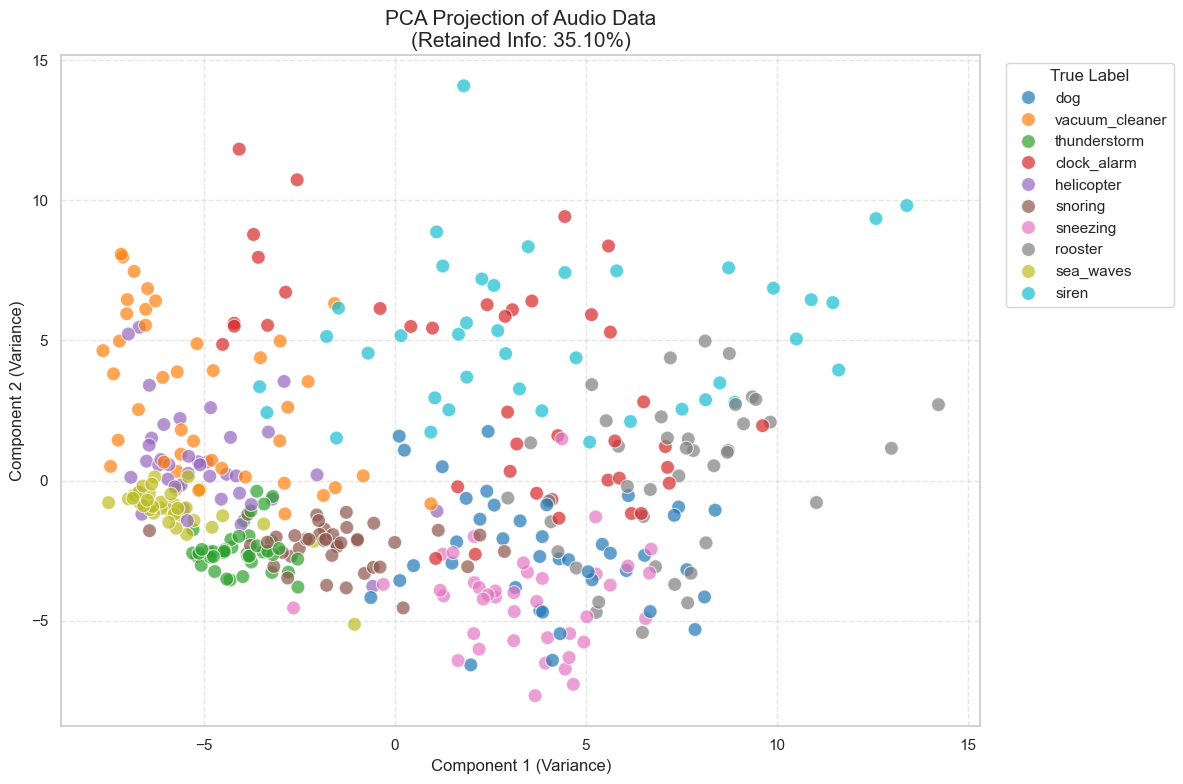

In [4]:
# Run PCA (Compress 80 features -> 2 features)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Calculate how much "truth" was preserved in this compression
explained_variance = sum(pca.explained_variance_ratio_) * 100

print(f" PCA Complete.")
print(f"   Information Retained: {explained_variance:.2f}%")
print(f"   (If this is low, <40%, the plot might be messy. If high, it's accurate.)")

# Plot the 2D Map
plt.figure(figsize=(12, 8))


# to check if the math successfully grouped similar sounds together.
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=y, 
    palette='tab10', 
    s=100,           # Dot size
    alpha=0.7        # Transparency
)

plt.title(f'PCA Projection of Audio Data\n(Retained Info: {explained_variance:.2f}%)', fontsize=15)
plt.xlabel('Component 1 (Variance)')
plt.ylabel('Component 2 (Variance)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="True Label")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

 Calculating Elbow Curve (this takes a moment)...


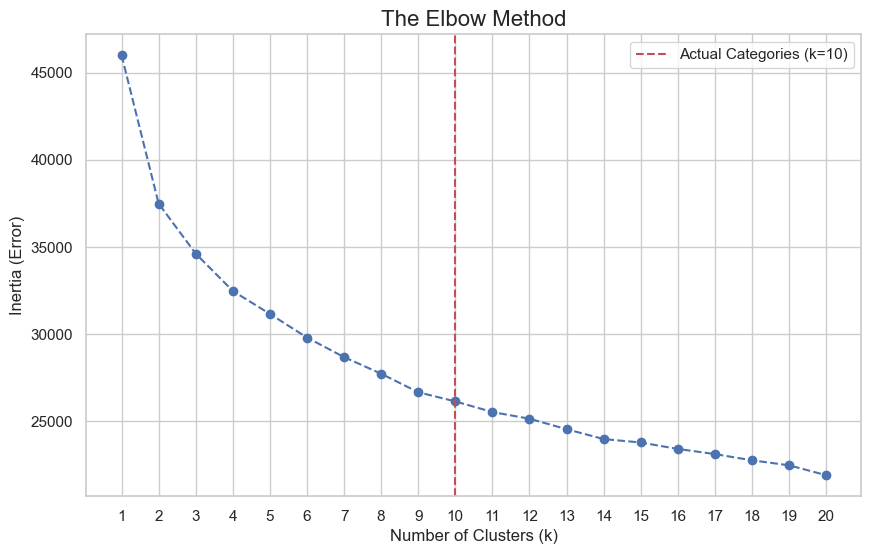

In [5]:
# Calculate Inertia for k=1 to 20 
print(" Calculating Elbow Curve (this takes a moment)...")

inertia = []
K_range = range(1, 21)

for k in K_range:
    # Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    # Inertia = Sum of distances of samples to their closest cluster center
    inertia.append(kmeans.inertia_)

# Plot the Result
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='b')

# Add a vertical line at k=10 (Our Ground Truth) for comparison
plt.axvline(x=10, color='r', linestyle='--', label='Actual Categories (k=10)')

plt.title('The Elbow Method', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Error)', fontsize=12)
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.show()


Observation:The resulting Elbow Curve does not verify a distinct, sharp inflection point at $k=10$. Instead, the curve shows a gradual, smooth decay in inertia as the number of clusters increases.Analysis:The absence of a sharp elbow suggests that the boundaries between the sound categories in the feature space are not strictly linear or isolated. There is likely significant acoustic overlap between certain categories (e.g., similar frequency patterns in 'Rain' and 'Sea Waves').Conclusion:While the Elbow Method does not mathematically confirm a single optimal $k$, it shows that increasing clusters beyond $k=10$ yields diminishing returns in reducing error. Therefore, we proceed with $k=10$ based on our domain knowledge (Ground Truth), as the dataset is constructed from exactly 10 distinct audio classes.

 Running K-Means (k=10)...
 Clustering Complete!


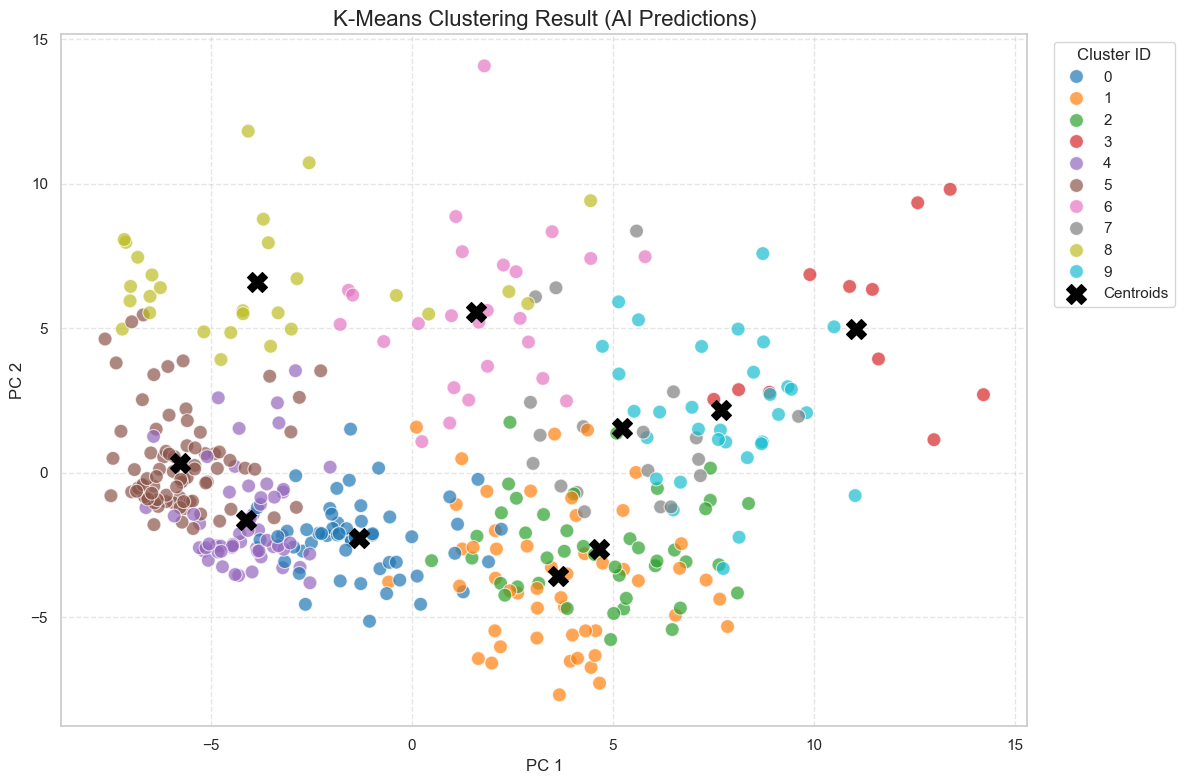

 Interpretation:
   - Each color represents a group created by the AI.
   - The Black 'X' is the center of that group.
   - Next Step: We must check if 'Cluster 0' actually corresponds to 'Dog' or something else.


In [6]:
# Run K-Means Algorithm
# We force it to find 10 clusters (k=10)
print(" Running K-Means (k=10)...")
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)

# The model assigns a number (0 to 9) to every audio file
predicted_labels = kmeans.fit_predict(X_scaled)

print(" Clustering Complete!")

# Visualize the PREDICTED Clusters
# Compare this plot with the one from Cell 3.
# Cell 3 showed "True Categories". This shows "What the AI thinks".

plt.figure(figsize=(12, 8))

# Scatter plot: Color by PREDICTED cluster (predicted_labels)
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=predicted_labels,  
    palette='tab10', 
    s=100, 
    alpha=0.7
)

# Mark the "Centroids" (The mathematical center of each cluster)
# We calculate where these centers are in the 2D map
centers_2d = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, marker='X', label='Centroids')

plt.title('K-Means Clustering Result (AI Predictions)', fontsize=16)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Cluster ID")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(" Interpretation:")
print("   - Each color represents a group created by the AI.")
print("   - The Black 'X' is the center of that group.")
print("   - Next Step: We must check if 'Cluster 0' actually corresponds to 'Dog' or something else.")

 Mapping Clusters to Categories:
------------------------------
   Cluster 0 (53 items) --> Mainly: 'snoring'
   Cluster 1 (51 items) --> Mainly: 'sneezing'
   Cluster 2 (42 items) --> Mainly: 'dog'
   Cluster 3 (11 items) --> Mainly: 'siren'
   Cluster 4 (57 items) --> Mainly: 'thunderstorm'
   Cluster 5 (82 items) --> Mainly: 'sea_waves'
   Cluster 6 (25 items) --> Mainly: 'siren'
   Cluster 7 (19 items) --> Mainly: 'clock_alarm'
   Cluster 8 (28 items) --> Mainly: 'vacuum_cleaner'
   Cluster 9 (32 items) --> Mainly: 'rooster'
------------------------------
 Final Unsupervised Accuracy: 65.25%
(Note: For Unsupervised Audio, 30-50% is considered decent. Don't expect 90%!)


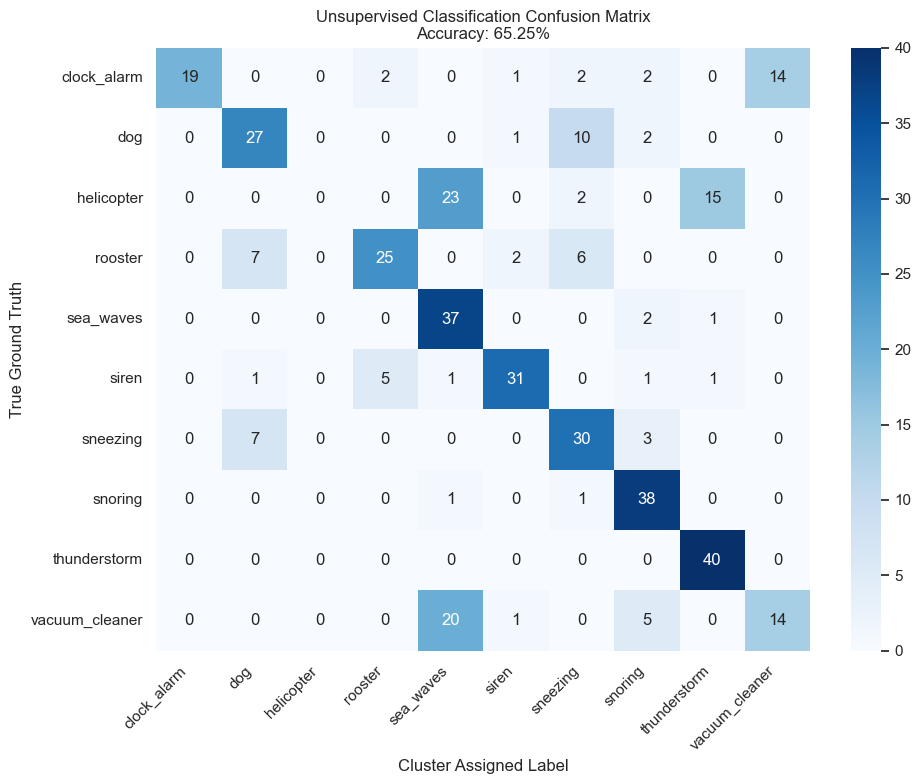

In [7]:
# Map Clusters to Real Names
# Logic: Look inside each cluster. If 80% of points are "Dog", label the cluster "Dog".
labels_map = {}
y_pred_named = np.array(["Unassigned"] * len(y), dtype=object)

print(" Mapping Clusters to Categories:")
print("-" * 30)

for cluster_id in range(10):
    # Find index of all points in this cluster
    indices = np.where(predicted_labels == cluster_id)[0]
    
    if len(indices) > 0:
        # Get the TRUE labels for these points
        true_labels_in_cluster = y[indices]
        
        # Find the most frequent label (Vote)
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        
        # Assign this name to the cluster
        labels_map[cluster_id] = most_common_label
        y_pred_named[indices] = most_common_label
        
        count = len(indices)
        print(f"   Cluster {cluster_id} ({count} items) --> Mainly: '{most_common_label}'")

# Calculate Accuracy
acc = accuracy_score(y, y_pred_named)
print("-" * 30)
print(f" Final Unsupervised Accuracy: {acc:.2%}")
print("(Note: For Unsupervised Audio, 30-50% is considered decent. Don't expect 90%!)")

# Confusion Matrix 
plt.figure(figsize=(10, 8))
unique_labels = sorted(list(set(y))) 

cm = confusion_matrix(y, y_pred_named, labels=unique_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, yticklabels=unique_labels)

plt.title(f'Unsupervised Classification Confusion Matrix\nAccuracy: {acc:.2%}')
plt.xlabel('Cluster Assigned Label')
plt.ylabel('True Ground Truth')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Hierarchical Clustering (Agglomerative)

Unlike K-Means, which partitions the data into flat clusters, **Hierarchical Clustering** builds a tree structure (Dendrogram) of the data. We use the **Agglomerative** approach, which treats each audio file as a singleton cluster and pairs them up as it moves up the hierarchy.

**Why use this?**
- It reveals the nested relationships between sounds (e.g., distinguishing how closely related "Rain" is to "Sea Waves" versus "Engine Noise").
- It allows us to visualize the structure via a Dendrogram before deciding on the number of clusters.

**Parameters:**
- **Linkage:** `ward` (Minimizes the variance of the clusters being merged).
- **Metric:** `euclidean` (Standard distance measure).

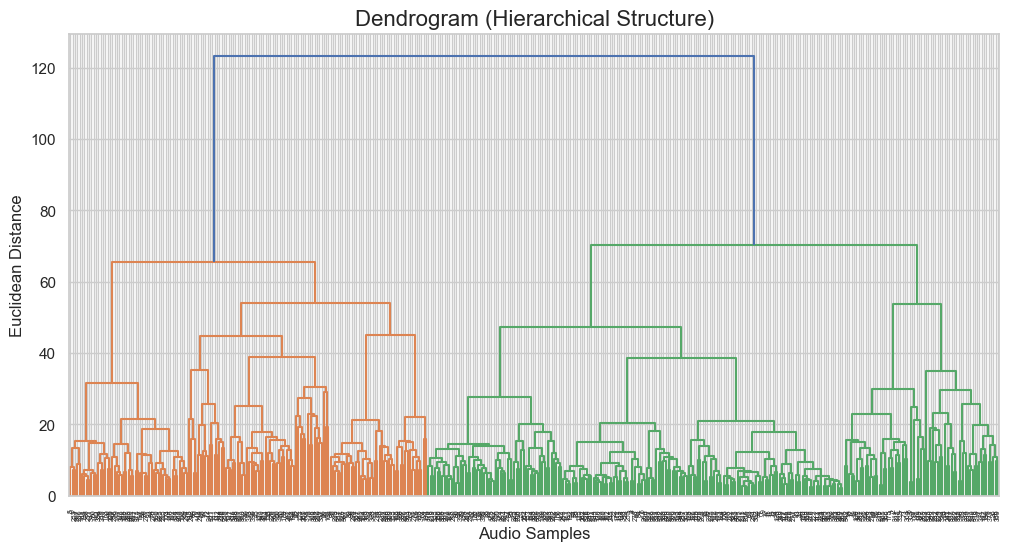

 Running Agglomerative Clustering (k=10)...
 Hierarchical Clustering Accuracy: 63.50%


In [8]:
# Visualize the Dendrogram
# The Dendrogram shows the hierarchical merging of clusters.
plt.figure(figsize=(12, 6))
plt.title("Dendrogram (Hierarchical Structure)", fontsize=16)

# 'ward' linkage minimizes the variance of the clusters being merged.
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method='ward'))

plt.xlabel('Audio Samples')
plt.ylabel('Euclidean Distance')
plt.show()

# --- 2. Train the Model ---
print(" Running Agglomerative Clustering (k=10)...")
# We specify n_clusters=10 to match our ground truth
hc = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')
y_hc_pred = hc.fit_predict(X_scaled)

# Evaluate & Map Labels
# We map the anonymous cluster IDs (0-9) to the most frequent true label in that cluster.
labels_map_hc = {}
y_hc_named = np.array(["Unassigned"] * len(y), dtype=object)

for cluster_id in range(10):
    indices = np.where(y_hc_pred == cluster_id)[0]
    
    if len(indices) > 0:
        true_labels = y[indices]
        most_common = Counter(true_labels).most_common(1)[0][0]
        y_hc_named[indices] = most_common
        labels_map_hc[cluster_id] = most_common

# Calculate Accuracy
hc_acc = accuracy_score(y, y_hc_named)
print(f" Hierarchical Clustering Accuracy: {hc_acc:.2%}")

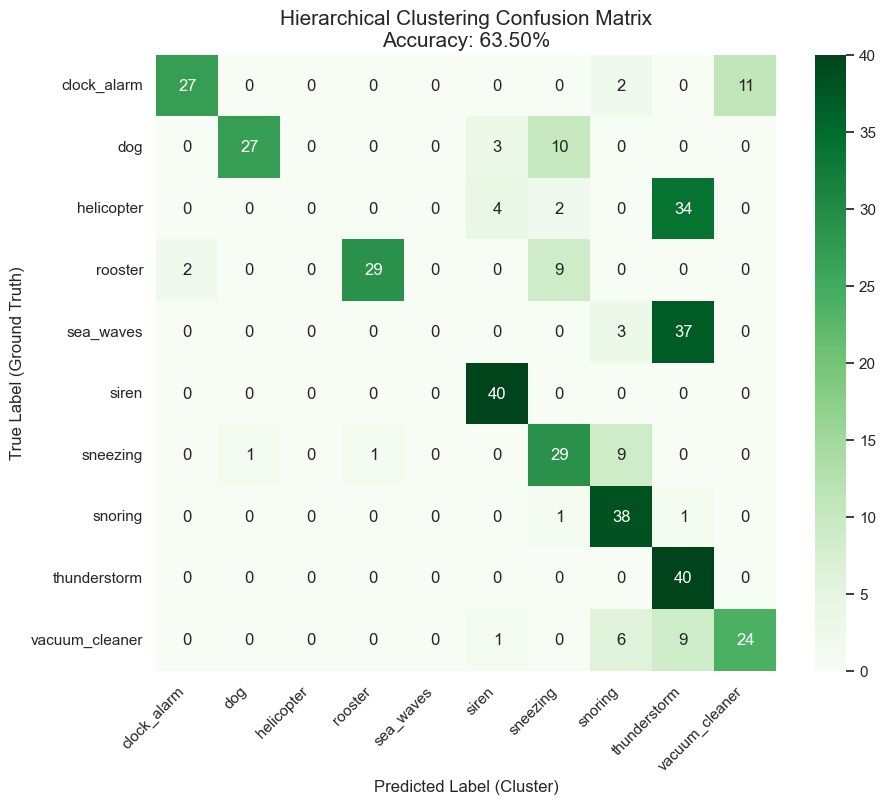

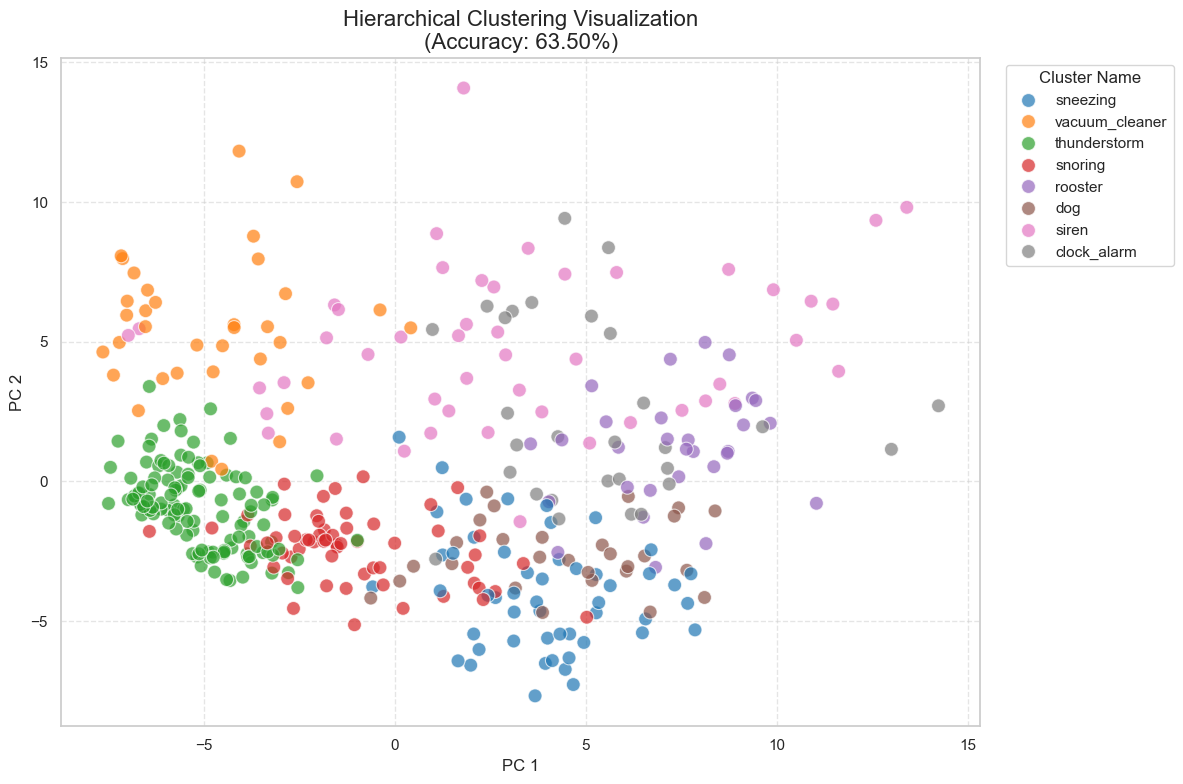

In [9]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
unique_labels = sorted(list(set(y)))

# Create the matrix comparing True Labels vs Hierarchical Predictions
cm_hc = confusion_matrix(y, y_hc_named, labels=unique_labels)

sns.heatmap(cm_hc, annot=True, fmt='d', cmap='Greens', 
            xticklabels=unique_labels, yticklabels=unique_labels)

plt.title(f'Hierarchical Clustering Confusion Matrix\nAccuracy: {hc_acc:.2%}', fontsize=15)
plt.xlabel('Predicted Label (Cluster)')
plt.ylabel('True Label (Ground Truth)')
plt.xticks(rotation=45, ha='right')
plt.show()

# Visualization of Clusters (Scatter Plot)
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=y_hc_named,
    palette='tab10',
    s=100,
    alpha=0.7
)

plt.title(f'Hierarchical Clustering Visualization\n(Accuracy: {hc_acc:.2%})', fontsize=16)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Cluster Name")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Gaussian Mixture Models (GMM)

**Gaussian Mixture Models (GMM)** is a probabilistic clustering algorithm. Unlike K-Means, which assumes clusters are spherical (circular), GMM assumes clusters are **elliptical** (oval-shaped). This makes it much more flexible for complex audio features that may be stretched in certain dimensions.

**Why use this?**
- **Soft Clustering:** It calculates the *probability* of a sample belonging to a cluster, rather than a hard assignment.
- **Flexibility:** It adapts well to clusters of different sizes and shapes (e.g., if the "Wind" cluster is wide and scattered, but the "Clock" cluster is small and dense).

**Parameters:**
- `n_components`: 10 (Number of clusters).
- `covariance_type`: `full` (Allows each cluster to have its own general shape).

In [11]:
# Train the GMM Model
print(" Running Gaussian Mixture Models (GMM)...")

# n_components=10 matches our ground truth categories
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
y_gmm_pred = gmm.fit_predict(X_scaled)

# Evaluate & Map Labels
# We use the same majority-vote mapping logic to check accuracy
labels_map_gmm = {}
y_gmm_named = np.array(["Unassigned"] * len(y), dtype=object)

for cluster_id in range(10):
    indices = np.where(y_gmm_pred == cluster_id)[0]
    
    if len(indices) > 0:
        true_labels = y[indices]
        # Find the dominant label in this Gaussian cluster
        most_common = Counter(true_labels).most_common(1)[0][0]
        y_gmm_named[indices] = most_common
        labels_map_gmm[cluster_id] = most_common

# Calculate Accuracy
gmm_acc = accuracy_score(y, y_gmm_named)
print(f" GMM Accuracy: {gmm_acc:.2%}")

 Running Gaussian Mixture Models (GMM)...
 GMM Accuracy: 54.25%


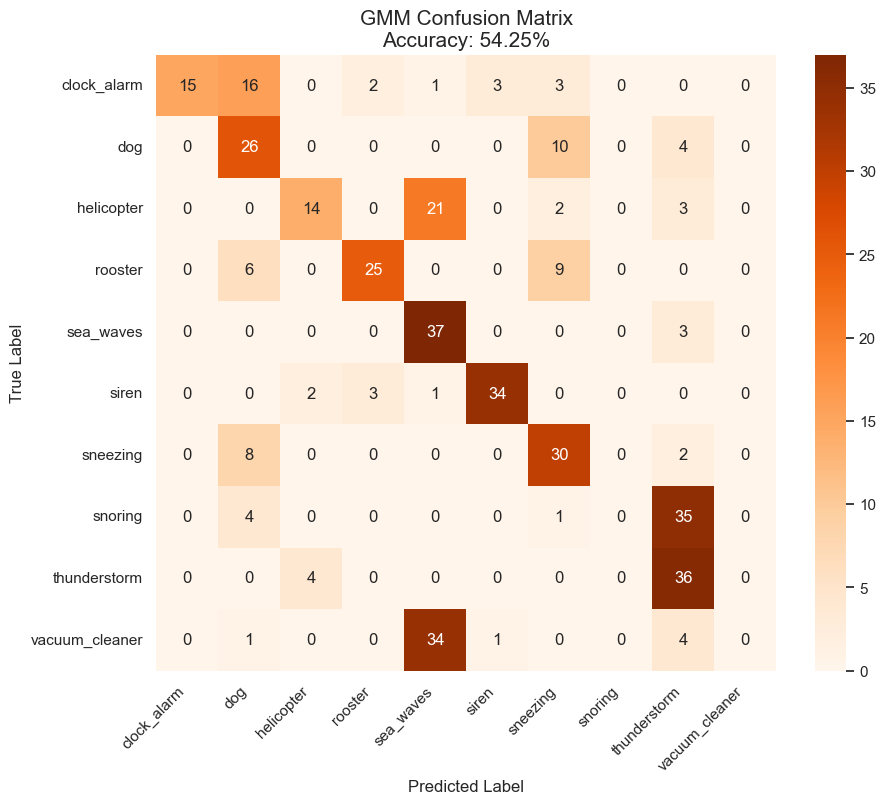

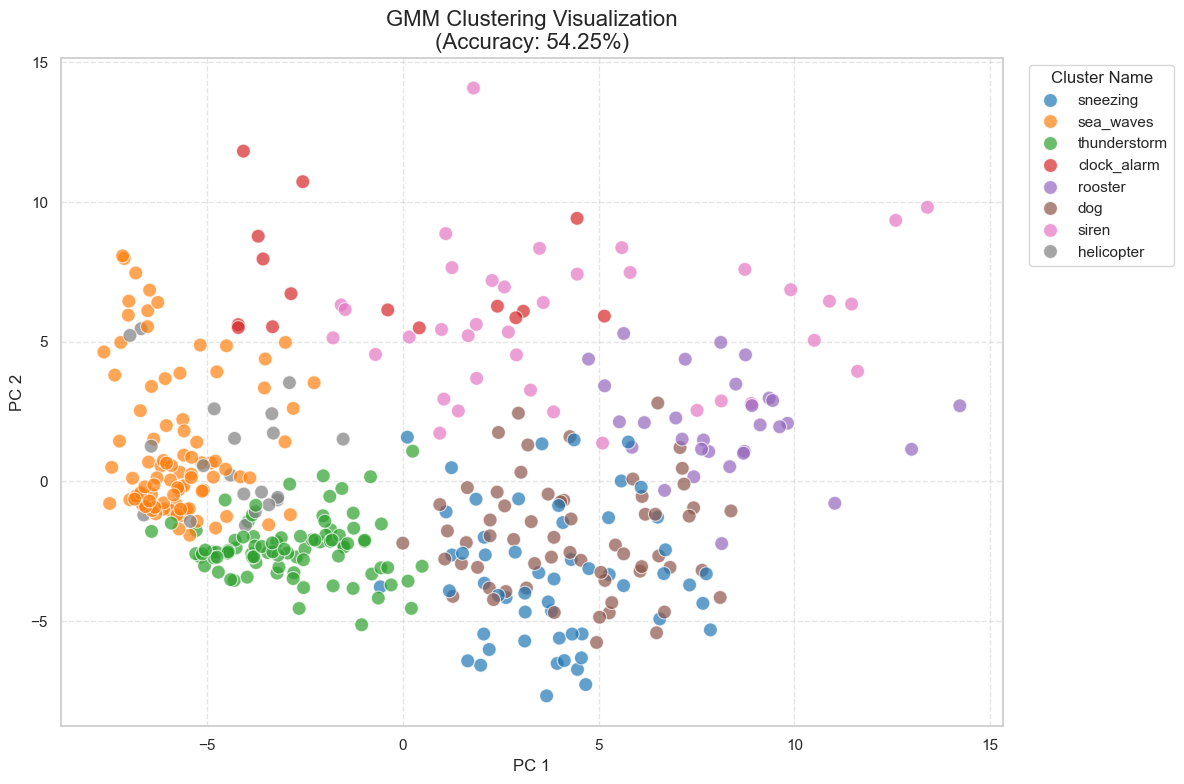

In [12]:
# GMM Confusion Matrix
plt.figure(figsize=(10, 8))

cm_gmm = confusion_matrix(y, y_gmm_named, labels=unique_labels)

sns.heatmap(cm_gmm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=unique_labels, yticklabels=unique_labels)

plt.title(f'GMM Confusion Matrix\nAccuracy: {gmm_acc:.2%}', fontsize=15)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.show()

# GMM Scatter Plot
plt.figure(figsize=(12, 8))

sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=y_gmm_named,
    palette='tab10',
    s=100,
    alpha=0.7
)

plt.title(f'GMM Clustering Visualization\n(Accuracy: {gmm_acc:.2%})', fontsize=16)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Cluster Name")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 4. Final Comparative Analysis

We conclude the experiment by comparing the performance of all three unsupervised algorithms side-by-side.
- **Quantitative:** We compare the classification accuracy (mapped from ground truth).
- **Qualitative:** We assess the suitability of each method based on the cluster shapes.

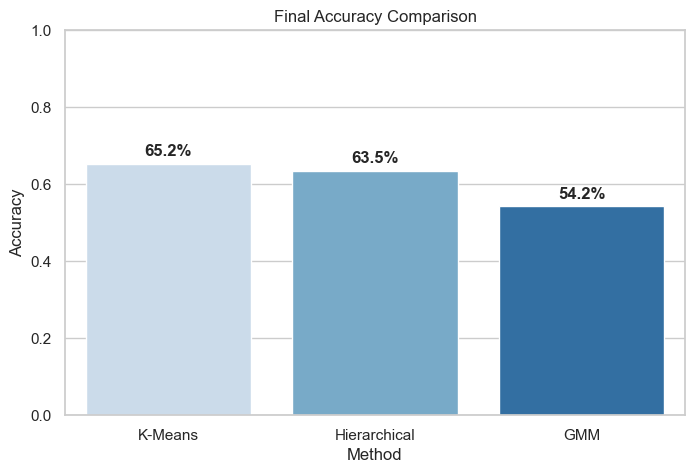


 RESULTS TABLE:


,Method,Accuracy
0,K-Means,0.6525
1,Hierarchical,0.6350
2,GMM,0.5425



✅ WINNER: K-Means with 65.2% accuracy.


In [13]:
# Create Comparison Data 
results = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical', 'GMM'],
    'Accuracy': [acc, hc_acc, gmm_acc]  
})

# Plot Simple Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Method', y='Accuracy', data=results, palette='Blues')
plt.title('Final Accuracy Comparison')
plt.ylim(0, 1.0) # Set Y-axis from 0% to 100%

# Add numbers on top of bars
for i, v in enumerate(results['Accuracy']):
    ax.text(i, v + 0.02, f"{v:.1%}", ha='center', fontweight='bold')

plt.show()

# Print Winner 
print("\n RESULTS TABLE:")
display(results)

winner = results.loc[results['Accuracy'].idxmax()]
print(f"\n✅ WINNER: {winner['Method']} with {winner['Accuracy']:.1%} accuracy.")